# Computational Statistics - Project
## Authors : Aurélie Wasem & Marcelo Tavares

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

### Dataset pre-process

In [51]:
np.random.seed(42)

# Load dataset
train_df = pd.read_csv('data/train.csv')

# Category variables
cat_vars = [
    'MSSubClass',
    'MSZoning',
    'Street',
    'Alley',
    'LotShape',
    'LandContour',
    'Utilities',
    'LotConfig',
    'LandSlope',
    'Neighborhood',
    'Condition1',
    'Condition2',
    'BldgType',
    'HouseStyle',
    'OverallQual',
    'OverallCond',
    'RoofStyle',
    'RoofMatl',
    'Exterior1st',
    'Exterior2nd',
    'MasVnrType',
    'ExterQual',
    'ExterCond',
    'Foundation',
    'BsmtQual',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'Heating',
    'HeatingQC',
    'CentralAir',
    'Electrical',
    'KitchenQual',
    'Functional',
    'FireplaceQu',
    'GarageType',
    'GarageFinish',
    'GarageQual',
    'GarageCond',
    'PavedDrive',
    'PoolQC',
    'Fence',
    'MiscFeature',
    'SaleType',
    'SaleCondition'
]

# Encode variables as category
for col in cat_vars:
    train_df[col] = train_df[col].astype('category')

# Convert categorical variables to dummy variables
df_encoded = pd.get_dummies(train_df, drop_first=True, dtype=int)


After the initial convertions of the data, we did some feature selection that will reduce the number of variables that we will work with.

### Features selection

           Feature  Importance
20      GarageCars    0.336756
12       GrLivArea    0.230165
9      TotalBsmtSF    0.081278
3        YearBuilt    0.059035
6       BsmtFinSF1    0.037667
4     YearRemodAdd    0.028931
156   ExterQual_Gd    0.021865
10        2ndFlrSF    0.019373
2          LotArea    0.014178
110  OverallQual_8    0.013172
15        FullBath    0.010648
19      Fireplaces    0.009579
1      LotFrontage    0.008631
5       MasVnrArea    0.007792
22     OpenPorchSF    0.006384
8        BsmtUnfSF    0.005458
109  OverallQual_7    0.005398
191   CentralAir_Y    0.005216
0               Id    0.005071
17    BedroomAbvGr    0.004729


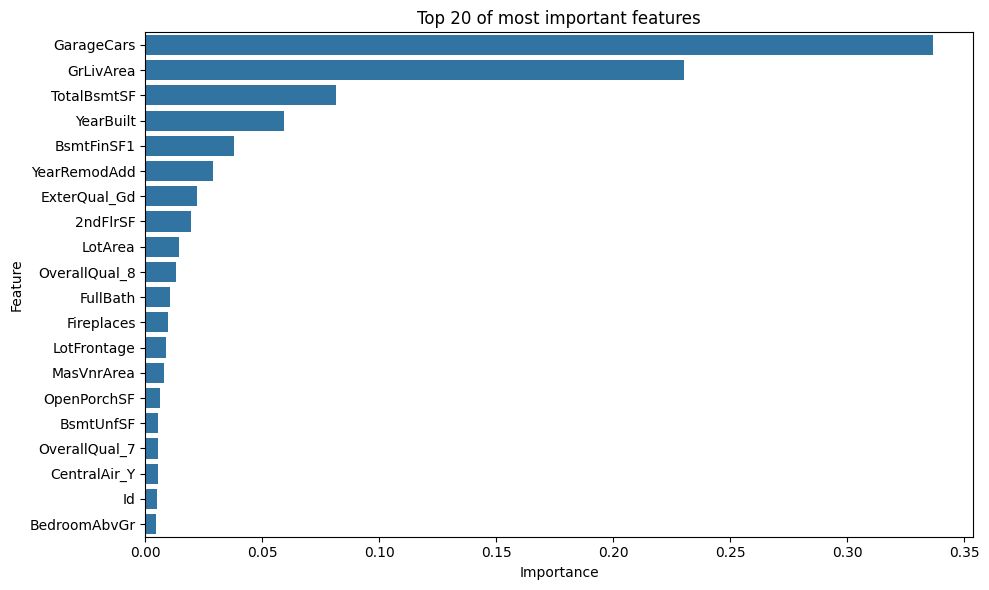

In [52]:
# Calculate the correlation matrix
corr_matrix = df_encoded.corr(numeric_only=True).abs()

# Select only the upper triangle to remove the redundant correlations
upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

# Find the columns to remove (strongly correlated > 0.75)
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]

# Remove those columns from the DataFrame
df_encoded = df_encoded.drop(columns=to_drop)

# Separate the features and the target
X = df_encoded.drop(columns=["SalePrice"])
y = df_encoded["SalePrice"]

# Initialise the Random Forest model
model = RandomForestRegressor(random_state=42)
model.fit(X, y)

# Get the importance of the features
importances = model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Print the top 20 of the most important features
print(importance_df.head(20))

# Barplot of the 20 most important features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title("Top 20 of most important features")
plt.tight_layout()
plt.show()


For the folllowing part of this project we select only the variables with an importance > 0.01.

In [53]:
# Select the variables with importance >0.01
top_features = importance_df[importance_df['Importance'] > 0.01]['Feature'].tolist()

# grades variable that we will help remap some variables
grades = {
    'Ex' : 5,
    'Gd' : 4,
    'TA' : 3,
    'Fa' : 2,
    'Po' : 1
}

# Creation of the filtered DataFrame with only the top features
top_features_df = df_encoded[top_features].drop(columns=['ExterQual_Gd','OverallQual_8'])
top_features_df['ExterQual'] = train_df['ExterQual'].map(grades).astype('int')
top_features_df['OverallQual'] = train_df['OverallQual'].astype('int')
top_features_df['SalePrice'] = y 

top_features_df

,GarageCars,GrLivArea,TotalBsmtSF,YearBuilt,BsmtFinSF1,YearRemodAdd,2ndFlrSF,LotArea,FullBath,ExterQual,OverallQual,SalePrice
0,2,1710,856,2003,706,2003,854,8450,2,4,7,208500
1,2,1262,1262,1976,978,1976,0,9600,2,3,6,181500
2,2,1786,920,2001,486,2002,866,11250,2,4,7,223500
3,3,1717,756,1915,216,1970,756,9550,1,3,7,140000
4,3,2198,1145,2000,655,2000,1053,14260,2,4,8,250000
...,...,...,...,...,...,...,...,...,...,...,...,...
1455,2,1647,953,1999,0,2000,694,7917,2,3,6,175000
1456,2,2073,1542,1978,790,1988,0,13175,2,3,6,210000
1457,1,2340,1152,1941,275,2006,1152,9042,2,5,7,266500
1458,1,1078,1078,1950,49,1996,0,9717,1,3,5,142125


### Data visualisation

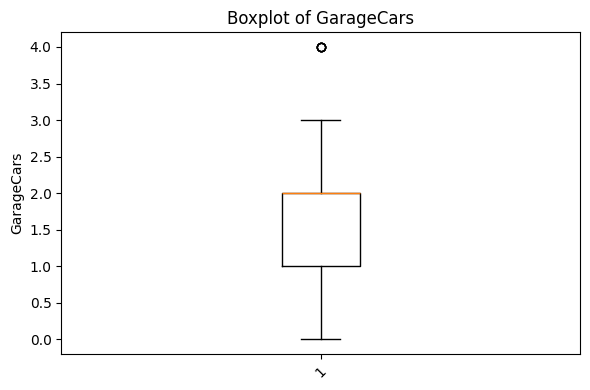

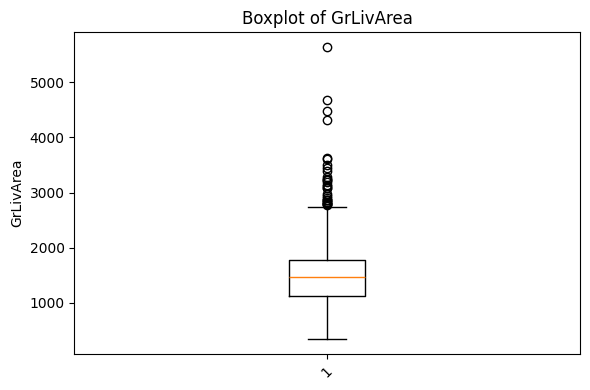

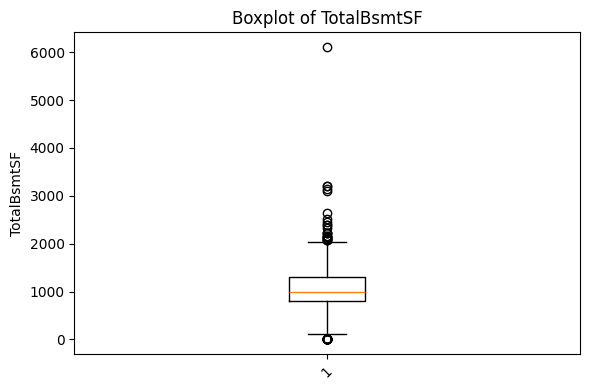

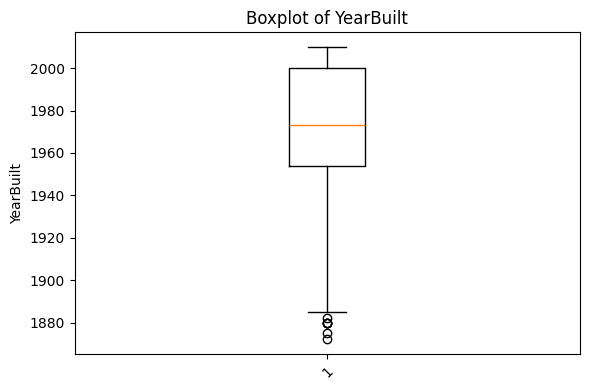

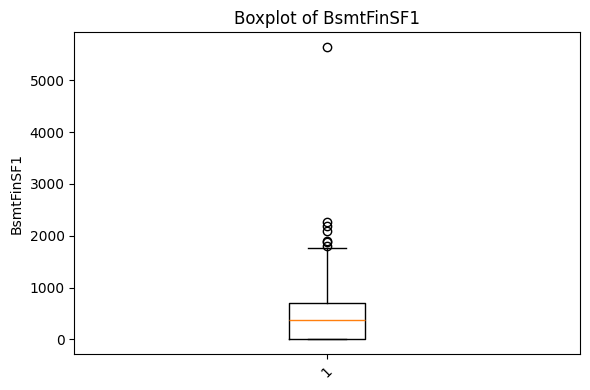

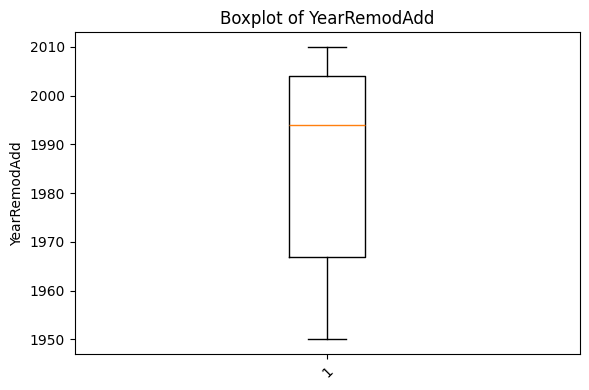

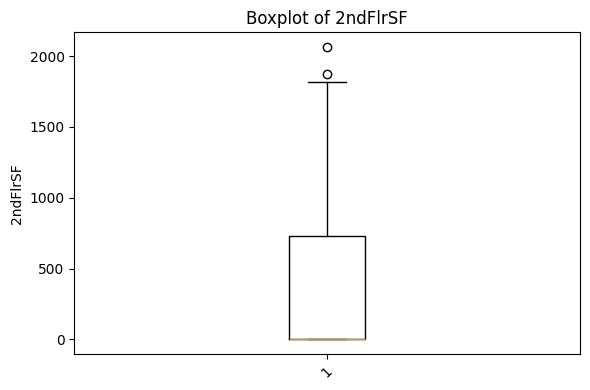

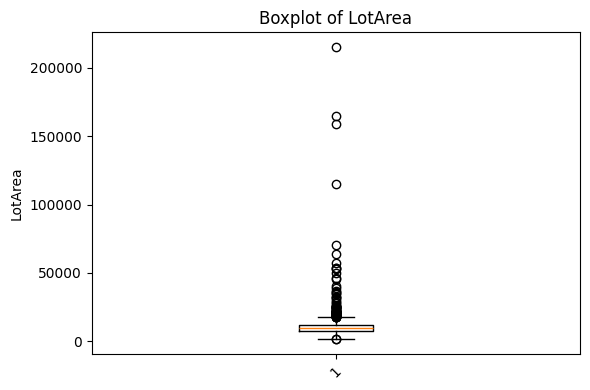

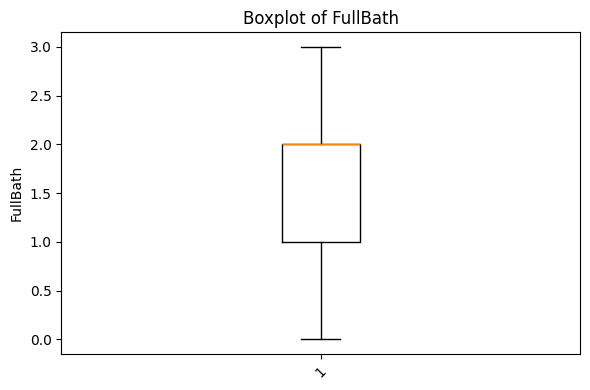

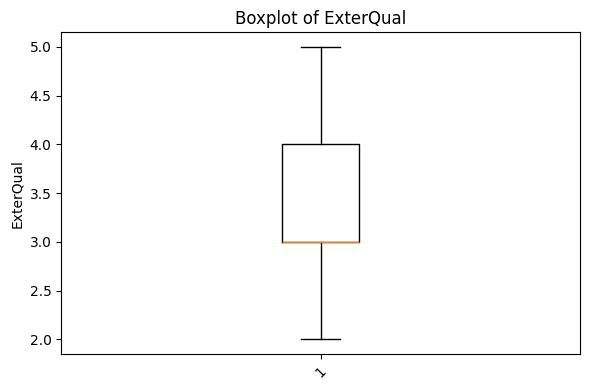

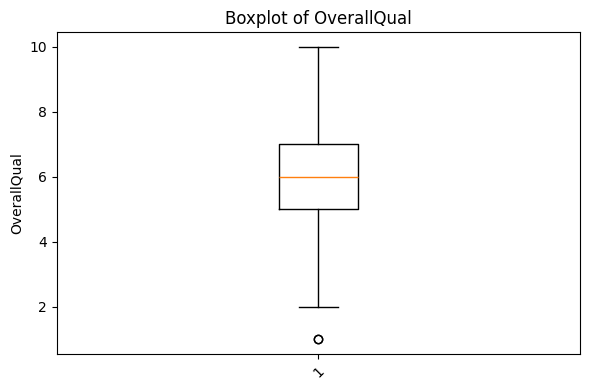

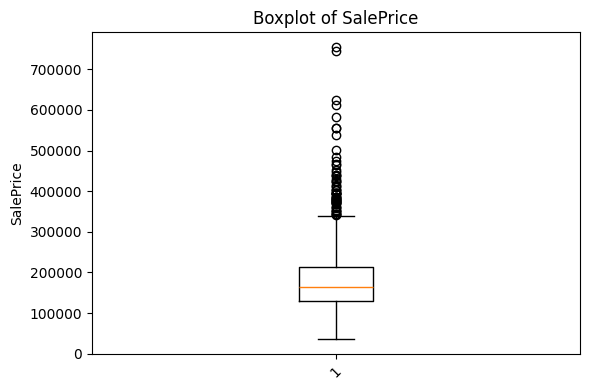

In [54]:
# Browse all columns and plot boxplots of their distributions
for column in top_features_df.columns:
    plt.figure(figsize=(6, 4))
    plt.boxplot(top_features_df[column].dropna())
    plt.title(f'Boxplot of {column}')
    plt.ylabel(column)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    plt.close()

We can see that some of our variables have values outside of the 1st and 3rd quartiles. Given this fact we will now do some data cleaning.

### Data cleaning

In [55]:
# Function to detect the outliers via the IQR method
def detect_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return lower, upper

# Stock the thresholds for each variable
outlier_bounds = []
outlier_filtered_df = top_features_df.copy()

# Browse all the top features and detect their outliers
for var in top_features_df.columns:
    if not pd.api.types.is_numeric_dtype(top_features_df[var]) or pd.api.types.is_bool_dtype(top_features_df[var]):
        continue
    series = top_features_df[var].dropna()
    lower, upper = detect_outliers_iqr(series)

    # Stock the bounds
    outlier_bounds.append({
        'Variable': var,
        'Lower Bound': lower,
        'Upper Bound': upper,
        'Nb Outliers (low)': (series < lower).sum(),
        'Nb Outliers (high)': (series > upper).sum()
    })

    # Remove the outliers in a copy of the DataFrame
    outlier_filtered_df = outlier_filtered_df[(outlier_filtered_df[var] >= lower) & (outlier_filtered_df[var] <= upper)]

# Save the filtered DataFrame without outliers for futur utilisation
filtered_df = outlier_filtered_df.copy().filter(top_features_df.columns)
filtered_df

,GarageCars,GrLivArea,TotalBsmtSF,YearBuilt,BsmtFinSF1,YearRemodAdd,2ndFlrSF,LotArea,FullBath,ExterQual,OverallQual,SalePrice
0,2,1710,856,2003,706,2003,854,8450,2,4,7,208500
1,2,1262,1262,1976,978,1976,0,9600,2,3,6,181500
2,2,1786,920,2001,486,2002,866,11250,2,4,7,223500
3,3,1717,756,1915,216,1970,756,9550,1,3,7,140000
4,3,2198,1145,2000,655,2000,1053,14260,2,4,8,250000
...,...,...,...,...,...,...,...,...,...,...,...,...
1455,2,1647,953,1999,0,2000,694,7917,2,3,6,175000
1456,2,2073,1542,1978,790,1988,0,13175,2,3,6,210000
1457,1,2340,1152,1941,275,2006,1152,9042,2,5,7,266500
1458,1,1078,1078,1950,49,1996,0,9717,1,3,5,142125


Now that our data is cleaned, we will try to do our first model

### Basic model

In [ ]:
# Variables for the linear regression
X = filtered_df.drop(columns='SalePrice')
y = filtered_df['SalePrice']

# Add a constant (intercept) to the model
X = sm.add_constant(X)

# Construction and fit of the model
model = sm.OLS(y, X).fit()

# Summary of the model
regression_summary = model.summary()
regression_summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     741.6
Date:                Mon, 26 May 2025   Prob (F-statistic):               0.00
Time:                        12:23:44   Log-Likelihood:                -14508.
No. Observations:                1275   AIC:                         2.904e+04
Df Residuals:                    1263   BIC:                         2.910e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1.122e+06   8.21e+04    -13.663      0.000   -1.28e+06   -9.61e+05
GarageCars    6380.9668   1157.076      5.515      0.000    4110.964    8650.969
GrLivArea       40.0070      4.222      9.475      0.000      31.724      48.290
TotalBsmtSF     25.4943      4.214      6.049      0.000      17.226      33.762
YearBuilt      201.5210     33.069      6.094      0.000     136.645     266.397
BsmtFinSF1      20.8008      1.658     12.546      0.000      17.548      24.053
YearRemodAdd   325.8329     39.822      8.182      0.000     247.708     403.958
2ndFlrSF         7.4890      4.222      1.774      0.076      -0.794      15.772
LotArea          2.2925      0.214     10.700      0.000       1.872       2.713
FullBath     -4785.2188   1695.287     -2.823      0.005   -8111.107   -1459.331
ExterQual     1.314e+04   1733.225      7.583      0.000    9741.985    1.65e+04
OverallQual   1.393e+04    804.222     17.322      0.000    1.24e+04    1.55e+04
==============================================================================
Omnibus:                       65.817   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              194.556
Skew:                          -0.192   Prob(JB):                     5.66e-43
Kurtosis:                       4.875   Cond. No.                     1.40e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.4e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Given that the $R^2$ is not very good and the high value of the AIC, we have to process our data.

### Classical statistical inference

In [57]:
# List to stock the results
regression_results = []

# For each variable in the dataset we calculated its mean, variance, did a simple linear regression, a t-test
# and calculated the confidence interval of the coefficient found except for the SalePrice where only mean and
# variance were calculated
for var in filtered_df.columns:
    if var == 'SalePrice':
        regression_results.append({
        'Variable': var,
        'Mean': filtered_df[var].mean(),
        'Variance': filtered_df[var].var()
    })
        continue
    mean = filtered_df[var].mean()
    variance = filtered_df[var].var()
    
    # Preparation of the data
    X = filtered_df[[var]]
    y = filtered_df.loc[X.index, 'SalePrice']
    
    # Linear Regression with sklearn module
    model = LinearRegression().fit(X, y)
    coef = model.coef_[0]
    intercept = model.intercept_
    
    # Predictions and standard errors of the coefficient
    y_pred = model.predict(X)
    residuals = y - y_pred
    n = len(y)
    X_mean = np.mean(X[var])
    s_squared = np.sum((residuals)**2) / (n - 2)
    se_beta = np.sqrt(s_squared / np.sum((X[var] - X_mean)**2))
    
    # Statistics of the hypothesis test H0: beta ≠ 0 (significant impact)
    t_stat = coef / se_beta
    p_value = 2 * (1 - stats.t.cdf(np.abs(t_stat), df=n - 2))
    
    # 95% confidence interval of the coefficient  
    ci_low = coef - stats.t.ppf(0.975, df=n - 2) * se_beta
    ci_high = coef + stats.t.ppf(0.975, df=n - 2) * se_beta

    # Stock the results in a list object    
    regression_results.append({
        'Variable': var,
        'Mean': mean,
        'Variance': variance,
        'Coefficient': coef,
        'CI 95% Lower': ci_low,
        'CI 95% Upper': ci_high,
        'T-statistic (H0: impact)': t_stat,
        'P-value': p_value,
        'Significant ?': 'Yes' if p_value < 0.05 else 'No'
    })

# Convert the list object to a DataFrame object
regression_df = pd.DataFrame(regression_results)

regression_df

,Variable,Mean,Variance,Coefficient,CI 95% Lower,CI 95% Upper,T-statistic (H0: impact),P-value,Significant ?
0,GarageCars,1.706667,5.010152e-01,53519.434889,50127.987569,56910.882209,30.959052,0.0,Yes
1,GrLivArea,1440.585882,1.780270e+05,95.432938,90.028719,100.837158,34.643881,0.0,Yes
2,TotalBsmtSF,1030.854902,1.071431e+05,101.906910,93.977110,109.836710,25.211727,0.0,Yes
3,YearBuilt,1971.332549,8.844655e+02,1199.341164,1115.245814,1283.436514,27.978985,0.0,Yes
4,BsmtFinSF1,415.620392,1.564117e+05,41.115668,33.403910,48.827425,10.459603,0.0,Yes
5,YearRemodAdd,1984.780392,4.219407e+02,1572.886630,1444.587807,1701.185453,24.051156,0.0,Yes
6,2ndFlrSF,328.149804,1.668390e+05,41.934160,34.502515,49.365804,11.069913,0.0,Yes
7,LotArea,9092.991373,9.920550e+06,7.125373,6.195464,8.055283,15.032398,0.0,Yes
8,FullBath,1.523922,2.763111e-01,65994.256398,61157.880258,70830.632538,26.769933,0.0,Yes
9,ExterQual,3.366275,2.793955e-01,74226.035381,69810.474670,78641.596091,32.978554,0.0,Yes


### Factorial design  

In [58]:
# Creation of the binarized columns
factorial_df = filtered_df.copy()

binarized_cols = []

for var in factorial_df.drop(columns='SalePrice').columns:
    median = factorial_df[var].median()
    bin_col = f"{var}_bin"
    factorial_df[bin_col] = factorial_df[var].apply(lambda x: 1 if x >= median else -1)
    binarized_cols.append(bin_col)

# Extract only the binarized columns
binarized_df = factorial_df[binarized_cols]

binarized_df

,GarageCars_bin,GrLivArea_bin,TotalBsmtSF_bin,YearBuilt_bin,BsmtFinSF1_bin,YearRemodAdd_bin,2ndFlrSF_bin,LotArea_bin,FullBath_bin,ExterQual_bin,OverallQual_bin
0,1,1,-1,1,1,1,1,-1,1,1,1
1,1,-1,1,1,1,-1,1,1,1,1,1
2,1,1,-1,1,1,1,1,1,1,1,1
3,1,1,-1,-1,-1,-1,1,1,-1,1,1
4,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
1455,1,1,-1,1,-1,1,1,-1,1,1,1
1456,1,1,1,1,1,-1,1,1,1,1,1
1457,-1,1,1,-1,-1,1,1,-1,1,1,1
1458,-1,-1,1,-1,-1,1,1,1,-1,1,-1


#### $2^{k-p}$

In [59]:
# Define the 5 base factors 
base_factors_fractional = ['GarageCars_bin', 'GrLivArea_bin', 'TotalBsmtSF_bin', 'YearBuilt_bin', 'BsmtFinSF1_bin']

# Define the 6 alias
generators = {
    # variable : [list of the base factors to multiply]
    'F' : ['GarageCars_bin', 'GrLivArea_bin'],
    'G' : ['GarageCars_bin', 'TotalBsmtSF_bin'],
    'H' : ['GrLivArea_bin', 'YearBuilt_bin'],
    'I' : ['TotalBsmtSF_bin', 'BsmtFinSF1_bin'],
    'J': ['GrLivArea_bin', 'BsmtFinSF1_bin'],
    'K': ['GarageCars_bin', 'YearBuilt_bin'],
}

# Generate the 32 experiments in -1 / +1 for the 5 factors
plan_2k_fractional = list(itertools.product([-1, 1], repeat=len(base_factors_fractional)))
plan_df_fractional = pd.DataFrame(plan_2k_fractional, columns=base_factors_fractional)

# Complete for the 6 aliased columns
for var, deps in generators.items():
    plan_df_fractional[var] = plan_df_fractional[deps].prod(axis=1)

# Associate the lines of the plan to the SalePrice meanse
saleprice_list_fractional = []
for _, row in plan_df_fractional.iterrows():
    condition = (factorial_df[base_factors_fractional[0]] == row[base_factors_fractional[0]])
    for col in base_factors_fractional[1:]:
        condition &= (factorial_df[col] == row[col])
    matched_rows = factorial_df[condition]
    mean_price = matched_rows['SalePrice'].mean() if not matched_rows.empty else None
    saleprice_list_fractional.append(mean_price)

plan_df_fractional['MeanSalePrice'] = saleprice_list_fractional
plan_df_cleaned_factorial = plan_df_fractional.dropna(subset=['MeanSalePrice']).copy()

plan_df_cleaned_factorial

,GarageCars_bin,GrLivArea_bin,TotalBsmtSF_bin,YearBuilt_bin,BsmtFinSF1_bin,F,G,H,I,J,K,MeanSalePrice
0,-1,-1,-1,-1,-1,1,1,1,1,1,1,103598.261538
1,-1,-1,-1,-1,1,1,1,1,-1,-1,1,116805.319444
2,-1,-1,-1,1,-1,1,1,-1,1,1,-1,109438.461538
3,-1,-1,-1,1,1,1,1,-1,-1,-1,-1,123727.272727
4,-1,-1,1,-1,-1,1,-1,1,-1,1,1,126368.275862
5,-1,-1,1,-1,1,1,-1,1,1,-1,1,139885.849057
6,-1,-1,1,1,-1,1,-1,-1,-1,1,-1,129750.000000
7,-1,-1,1,1,1,1,-1,-1,1,-1,-1,143055.555556
8,-1,1,-1,-1,-1,-1,1,-1,1,-1,1,138311.895833
9,-1,1,-1,-1,1,-1,1,-1,-1,1,1,164250.000000


##### ANOVA

In [60]:
# ANOVA
# Create the formula used in the model
formula = 'MeanSalePrice ~ ' + ' + '.join(plan_df_cleaned_factorial.columns[:-1])

# Redo the OLS model and the ANOVA
model = smf.ols(formula=formula, data=plan_df_cleaned_factorial).fit()

anova_table = sm.stats.anova_lm(model, typ=2).reset_index().rename(columns={
    'index': 'Variable',
    'sum_sq': 'SS',
    'df': 'DF',
    'F': 'F',
    'PR(>F)': 'p_value'
})
anova_table['MS'] = anova_table['SS'] / anova_table['DF']
anova_table['Significant ?'] = anova_table['p_value'].apply(lambda p: 'Yes' if p < 0.05 else 'No')

# Total Row
total_ss = anova_table['SS'].sum()
total_df = anova_table['DF'].sum()
anova_total = pd.DataFrame([{
    'Variable': 'Total',
    'SS': total_ss,
    'DF': total_df,
    'MS': None,
    'F': None,
    'p_value': None,
    'Significant ?': ''
}])

# Concatenate the anova table with the total row
anova_full = pd.concat([anova_table, anova_total], ignore_index=True)
anova_full

C:\Users\marce\AppData\Local\Temp\ipykernel_27964\688075838.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  anova_full = pd.concat([anova_table, anova_total], ignore_index=True)


,Variable,SS,DF,F,p_value,MS,Significant ?
0,GarageCars_bin,1.032219e+10,1.0,59.687879,2.802365e-07,1.032219e+10,Yes
1,GrLivArea_bin,9.327185e+09,1.0,53.934289,5.829933e-07,9.327185e+09,Yes
2,TotalBsmtSF_bin,3.024836e+09,1.0,17.491060,5.053952e-04,3.024836e+09,Yes
3,YearBuilt_bin,2.010986e+09,1.0,11.628494,2.936877e-03,2.010986e+09,Yes
4,BsmtFinSF1_bin,7.366439e+08,1.0,4.259631,5.295778e-02,7.366439e+08,No
5,F,1.051848e+09,1.0,6.082293,2.334086e-02,1.051848e+09,Yes
6,G,8.356930e+07,1.0,0.483238,4.953739e-01,8.356930e+07,No
7,H,1.699915e+05,1.0,0.000983,9.753155e-01,1.699915e+05,No
8,I,9.933181e+04,1.0,0.000574,9.811294e-01,9.933181e+04,No
9,J,5.330698e+06,1.0,0.030825,8.624897e-01,5.330698e+06,No


Given the results obtained in this anova table, we will now do a regression model only including the significant main effects and interactions.

##### Regression

In [61]:
# List of the variables to keep (p-value < 0.05)
significant_vars = [
    'GarageCars', 'GrLivArea', 'TotalBsmtSF',
    'YearBuilt', 'GarageCars:GrLivArea', 'GarageCars:YearBuilt'
]

# Formula construction
formula = 'SalePrice ~ ' + ' + '.join(significant_vars)

# Fit the model and print its summary
model_reduced = smf.ols(formula=formula, data=filtered_df).fit()
model_summary = model_reduced.summary()
model_summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     783.3
Date:                Mon, 26 May 2025   Prob (F-statistic):               0.00
Time:                        12:23:44   Log-Likelihood:                -14801.
No. Observations:                1275   AIC:                         2.962e+04
Df Residuals:                    1268   BIC:                         2.965e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             -2.84e+05   1.38e+05     -2.052      0.040   -5.56e+05   -1.25e+04
GarageCars           -5.125e+05    7.4e+04     -6.923      0.000   -6.58e+05   -3.67e+05
GrLivArea               39.9608      4.725      8.458      0.000      30.691      49.230
TotalBsmtSF             38.5424      2.653     14.530      0.000      33.338      43.746
YearBuilt              163.9603     71.102      2.306      0.021      24.470     303.450
GarageCars:GrLivArea    13.2259      2.436      5.430      0.000       8.447      18.005
GarageCars:YearBuilt   258.7121     38.100      6.790      0.000     183.967     333.458
==============================================================================
Omnibus:                       85.833   Durbin-Watson:                   2.070
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              381.353
Skew:                           0.065   Prob(JB):                     1.55e-83
Kurtosis:                       5.676   Cond. No.                     1.10e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.1e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Since this model only explains 79% of the variability of house prices, which is worse than our first model, we will now try to do a $2^k$ factorial design 

#### $2^k$ factorial design

In [62]:
base_factors_full = ['GarageCars_bin', 'GrLivArea_bin', 'TotalBsmtSF_bin', 'YearBuilt_bin', 'BsmtFinSF1_bin', 'YearRemodAdd_bin', '2ndFlrSF_bin', 'LotArea_bin', 'FullBath_bin', 'ExterQual_bin', 'OverallQual_bin']

plan_2k_full = list(itertools.product([-1, 1], repeat=len(base_factors_full)))
plan_df_full = pd.DataFrame(plan_2k_full, columns=base_factors_full)

# Associate the rows of the plan to the SalePrice means
saleprice_list_full = []
for _, row in plan_df_full.iterrows():
    condition = (factorial_df[base_factors_full[0]] == row[base_factors_full[0]])
    for col in base_factors_full[1:]:
        condition &= (factorial_df[col] == row[col])
    matched_rows = factorial_df[condition]
    mean_price = matched_rows['SalePrice'].mean() if not matched_rows.empty else None
    saleprice_list_full.append(mean_price)

plan_df_full['MeanSalePrice'] = saleprice_list_full
plan_df_cleaned_full = plan_df_full.dropna(subset=['MeanSalePrice']).copy()

plan_df_cleaned_full

,GarageCars_bin,GrLivArea_bin,TotalBsmtSF_bin,YearBuilt_bin,BsmtFinSF1_bin,YearRemodAdd_bin,2ndFlrSF_bin,LotArea_bin,FullBath_bin,ExterQual_bin,OverallQual_bin,MeanSalePrice
16,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,82375.000000
18,-1,-1,-1,-1,-1,-1,1,-1,-1,1,-1,94692.500000
19,-1,-1,-1,-1,-1,-1,1,-1,-1,1,1,113542.315789
22,-1,-1,-1,-1,-1,-1,1,-1,1,1,-1,108166.666667
23,-1,-1,-1,-1,-1,-1,1,-1,1,1,1,119500.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2035,1,1,1,1,1,1,1,-1,-1,1,1,286000.000000
2039,1,1,1,1,1,1,1,-1,1,1,1,242632.344828
2043,1,1,1,1,1,1,1,1,-1,1,1,285182.000000
2046,1,1,1,1,1,1,1,1,1,1,-1,218000.000000


##### ANOVA

In [63]:
# Rename the problematic column
plan_df_cleaned = plan_df_cleaned_full.rename(columns={"2ndFlrSF_bin": "SecondFlrSF_bin"})

# Regression and ANOVA
# Update the formula with the right names of the columns
formula = 'MeanSalePrice ~ ' + ' + '.join(plan_df_cleaned.columns[:-1])

# Redo the model and the ANOVA table
model = smf.ols(formula=formula, data=plan_df_cleaned).fit()

anova_table = sm.stats.anova_lm(model, typ=2).reset_index().rename(columns={
    'index': 'Variable',
    'sum_sq': 'SS',
    'df': 'DF',
    'F': 'F',
    'PR(>F)': 'p_value'
})
anova_table['MS'] = anova_table['SS'] / anova_table['DF']
anova_table['Significant ?'] = anova_table['p_value'].apply(lambda p: 'Yes' if p < 0.05 else 'No')

# Total Row of the ANOVA table
total_ss = anova_table['SS'].sum()
total_df = anova_table['DF'].sum()
anova_total = pd.DataFrame([{
    'Variable': 'Total',
    'SS': total_ss,
    'DF': total_df,
    'MS': None,
    'F': None,
    'p_value': None,
    'Significant ?': ''
}])

# Concatenate the ANOVA table with its total row
anova_full = pd.concat([anova_table, anova_total], ignore_index=True)
anova_full

C:\Users\marce\AppData\Local\Temp\ipykernel_27964\4165405121.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  anova_full = pd.concat([anova_table, anova_total], ignore_index=True)


,Variable,SS,DF,F,p_value,MS,Significant ?
0,GarageCars_bin,1.167532e+10,1.0,22.336615,3.844707e-06,1.167532e+10,Yes
1,GrLivArea_bin,5.745613e+10,1.0,109.922037,1.630514e-21,5.745613e+10,Yes
2,TotalBsmtSF_bin,1.507807e+10,1.0,28.846573,1.808128e-07,1.507807e+10,Yes
3,YearBuilt_bin,1.141593e+10,1.0,21.840350,4.874106e-06,1.141593e+10,Yes
4,BsmtFinSF1_bin,1.087878e+10,1.0,20.812707,7.982510e-06,1.087878e+10,Yes
5,YearRemodAdd_bin,1.763920e+10,1.0,33.746380,1.925406e-08,1.763920e+10,Yes
6,SecondFlrSF_bin,3.064189e+11,1.0,586.224547,3.670532e-67,3.064189e+11,Yes
7,LotArea_bin,8.558623e+09,1.0,16.373906,6.958324e-05,8.558623e+09,Yes
8,FullBath_bin,1.017819e+07,1.0,0.019472,8.891344e-01,1.017819e+07,No
9,ExterQual_bin,2.308722e+09,1.0,4.416926,3.659721e-02,2.308722e+09,Yes


##### Regression

In [ ]:
# List of the variables to keep (p-value < 0.05)
significant_vars = [
    'GarageCars', 'GrLivArea', 'TotalBsmtSF', 'YearBuilt', 'BsmtFinSF1', 'YearRemodAdd', 'SecondFlrSF', 'LotArea', 'ExterQual', 'OverallQual'
]

filtered_df = filtered_df.rename(columns={"2ndFlrSF": "SecondFlrSF"})

# Construction of the formula
formula = 'SalePrice ~ ' + ' + '.join(significant_vars)

# Create the model and print its summary
model_reduced = smf.ols(formula=formula, data=filtered_df).fit()
model_summary = model_reduced.summary()
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     810.5
Date:                Mon, 26 May 2025   Prob (F-statistic):               0.00
Time:                        12:23:47   Log-Likelihood:                -14512.
No. Observations:                1275   AIC:                         2.905e+04
Df Residuals:                    1264   BIC:                         2.910e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -1.049e+06   7.82e+04    -13.421      0.000    -1.2e+06   -8.96e+05
GarageCars    6273.8936   1159.637      5.410      0.000    3998.869    8548.919
GrLivArea       37.0767      4.104      9.034      0.000      29.025      45.128
TotalBsmtSF     25.0598      4.223      5.934      0.000      16.775      33.345
YearBuilt      175.5063     31.846      5.511      0.000     113.029     237.983
BsmtFinSF1      21.3824      1.650     12.962      0.000      18.146      24.619
YearRemodAdd   313.7257     39.700      7.903      0.000     235.841     391.610
SecondFlrSF      7.4767      4.234      1.766      0.078      -0.829      15.783
LotArea          2.3374      0.214     10.911      0.000       1.917       2.758
ExterQual     1.302e+04   1737.445      7.493      0.000    9610.514    1.64e+04
OverallQual   1.391e+04    806.394     17.247      0.000    1.23e+04    1.55e+04
==============================================================================
Omnibus:                       67.265   Durbin-Watson:                   2.050
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              203.583
Skew:                          -0.190   Prob(JB):                     6.20e-45
Kurtosis:                       4.920   Cond. No.                     1.33e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.33e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##### ANOVA from the new model

In [65]:
# ANOVA table from this new model
anova_table = sm.stats.anova_lm(model_reduced, typ=2).reset_index().rename(columns={
    'index': 'Variable',
    'sum_sq': 'SS',
    'df': 'DF',
    'F': 'F',
    'PR(>F)': 'p_value'
})
anova_table['MS'] = anova_table['SS'] / anova_table['DF']
anova_table['Significant ?'] = anova_table['p_value'].apply(lambda p: 'Yes' if p < 0.05 else 'No')

# Total Row of the ANOVA table
total_ss = anova_table['SS'].sum()
total_df = anova_table['DF'].sum()
anova_total = pd.DataFrame([{
    'Variable': 'Total',
    'SS': total_ss,
    'DF': total_df,
    'MS': None,
    'F': None,
    'p_value': None,
    'Significant ?': ''
}])

# Concatenate the anova table with its total row
anova_full = pd.concat([anova_table, anova_total], ignore_index=True)
anova_full

C:\Users\marce\AppData\Local\Temp\ipykernel_27964\1285504060.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  anova_full = pd.concat([anova_table, anova_total], ignore_index=True)


,Variable,SS,DF,F,p_value,MS,Significant ?
0,GarageCars,1.329836e+10,1.0,29.270507,7.522321e-08,1.329836e+10,Yes
1,GrLivArea,3.708235e+10,1.0,81.620510,6.017992e-19,3.708235e+10,Yes
2,TotalBsmtSF,1.599687e+10,1.0,35.210092,3.816986e-09,1.599687e+10,Yes
3,YearBuilt,1.379880e+10,1.0,30.371998,4.318242e-08,1.379880e+10,Yes
4,BsmtFinSF1,7.633127e+10,1.0,168.009795,3.631020e-36,7.633127e+10,Yes
5,YearRemodAdd,2.837246e+10,1.0,62.449521,5.908627e-15,2.837246e+10,Yes
6,SecondFlrSF,1.416947e+09,1.0,3.118787,7.763575e-02,1.416947e+09,No
7,LotArea,5.408405e+10,1.0,119.042309,1.500081e-26,5.408405e+10,Yes
8,ExterQual,2.550987e+10,1.0,56.148795,1.258067e-13,2.550987e+10,Yes
9,OverallQual,1.351430e+11,1.0,297.457912,5.041960e-60,1.351430e+11,Yes


##### New Regression

In [ ]:
# List of the variables to keep (p-value < 0.05)
significant_vars = [
    'GarageCars', 'GrLivArea', 'TotalBsmtSF', 'YearBuilt', 'BsmtFinSF1', 'YearRemodAdd', 'LotArea', 'ExterQual', 'OverallQual'
]

# Construction of the formula
formula = 'SalePrice ~ ' + ' + '.join(significant_vars)

# Create the model and print its summary
model_reduced = smf.ols(formula=formula, data=filtered_df).fit()
model_summary = model_reduced.summary()
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     898.7
Date:                Mon, 26 May 2025   Prob (F-statistic):               0.00
Time:                        12:24:35   Log-Likelihood:                -14513.
No. Observations:                1275   AIC:                         2.905e+04
Df Residuals:                    1265   BIC:                         2.910e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -1.059e+06    7.8e+04    -13.569      0.000   -1.21e+06   -9.06e+05
GarageCars    6188.4157   1159.596      5.337      0.000    3913.472    8463.359
GrLivArea       43.5371      1.862     23.386      0.000      39.885      47.189
TotalBsmtSF     18.8266      2.321      8.112      0.000      14.273      23.380
YearBuilt      187.3805     31.154      6.015      0.000     126.261     248.500
BsmtFinSF1      21.2416      1.649     12.881      0.000      18.006      24.477
YearRemodAdd   306.3850     39.514      7.754      0.000     228.864     383.906
LotArea          2.3010      0.213     10.782      0.000       1.882       2.720
ExterQual     1.325e+04   1733.886      7.643      0.000    9850.327    1.67e+04
OverallQual   1.396e+04    806.624     17.301      0.000    1.24e+04    1.55e+04
==============================================================================
Omnibus:                       66.832   Durbin-Watson:                   2.053
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              201.031
Skew:                          -0.190   Prob(JB):                     2.22e-44
Kurtosis:                       4.908   Cond. No.                     1.32e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.32e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##### ANOVA of the new Regression

In [80]:
# ANOVA table from this new model
anova_table = sm.stats.anova_lm(model_reduced, typ=2).reset_index().rename(columns={
    'index': 'Variable',
    'sum_sq': 'SS',
    'df': 'DF',
    'F': 'F',
    'PR(>F)': 'p_value'
})
anova_table['MS'] = anova_table['SS'] / anova_table['DF']
anova_table['Significant ?'] = anova_table['p_value'].apply(lambda p: 'Yes' if p < 0.05 else 'No')

# Total Row of the ANOVA table
total_ss = anova_table['SS'].sum()
total_df = anova_table['DF'].sum()
anova_total = pd.DataFrame([{
    'Variable': 'Total',
    'SS': total_ss,
    'DF': total_df,
    'MS': None,
    'F': None,
    'p_value': None,
    'Significant ?': ''
}])

# Concatenate the anova table with its total row
anova_full = pd.concat([anova_table, anova_total], ignore_index=True)
anova_full

C:\Users\marce\AppData\Local\Temp\ipykernel_27964\1285504060.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  anova_full = pd.concat([anova_table, anova_total], ignore_index=True)


,Variable,SS,DF,F,p_value,MS,Significant ?
0,GarageCars,1.296105e+10,1.0,28.480353,1.120723e-07,1.296105e+10,Yes
1,GrLivArea,2.488920e+11,1.0,546.910569,8.144936e-101,2.488920e+11,Yes
2,TotalBsmtSF,2.994405e+10,1.0,65.798468,1.171204e-15,2.994405e+10,Yes
3,YearBuilt,1.646300e+10,1.0,36.175470,2.356872e-09,1.646300e+10,Yes
4,BsmtFinSF1,7.550585e+10,1.0,165.915110,9.174501e-36,7.550585e+10,Yes
5,YearRemodAdd,2.736020e+10,1.0,60.120774,1.824595e-14,2.736020e+10,Yes
6,LotArea,5.290173e+10,1.0,116.245246,5.439791e-26,5.290173e+10,Yes
7,ExterQual,2.658352e+10,1.0,58.414106,4.177893e-14,2.658352e+10,Yes
8,OverallQual,1.362131e+11,1.0,299.312040,2.350641e-60,1.362131e+11,Yes
9,Residual,5.756854e+11,1265.0,NaN,NaN,4.550873e+08,No


### Predictions

Given the results obtained in the last model, we wanted to try and repredict the SalePrice given the data that we add and plot it against the real value

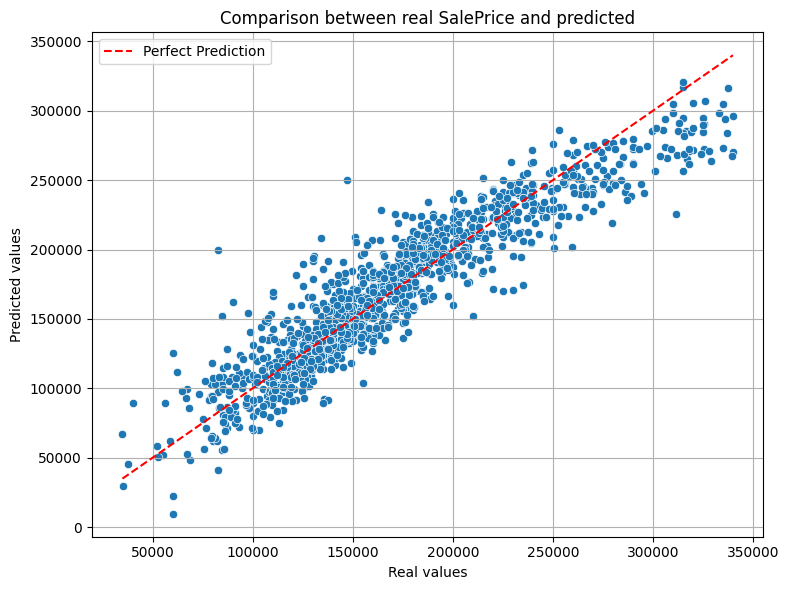

In [81]:
# Apply the model on the data and generate predictions
predictions = model_reduced.predict(filtered_df)

# Add the predictions to a new DataFrame
prediction_df = filtered_df.copy()
prediction_df['Predicted_SalePrice'] = predictions

# Plot the real values vs predicted values
plt.figure(figsize=(8, 6))
sns.scatterplot(x='SalePrice', y='Predicted_SalePrice', data=prediction_df)
plt.plot([prediction_df['SalePrice'].min(), prediction_df['SalePrice'].max()],
         [prediction_df['SalePrice'].min(), prediction_df['SalePrice'].max()],
         color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel("Real values")
plt.ylabel("Predicted values")
plt.title("Comparison between real SalePrice and predicted")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### SARIMA

The file contains 2 time variables, YrSold and MoSold, that we will use for the time series analysis.

In [67]:
time_df = train_df.copy()
# Create a new date column from the YrSold and MoSold variable
time_df['Date'] = pd.to_datetime(time_df['YrSold'].astype(str) + '-' + time_df['MoSold'].astype(str) + '-01')
time_df['Date'] = time_df['Date'].dropna()
time_df['SalePrice'] = time_df['SalePrice'].dropna()
# Group by month and year, then calculate the mean SalePrice
ts = time_df.groupby('Date')['SalePrice'].mean().sort_index()
ts = ts.asfreq('MS')


#### Temporal Series Plot

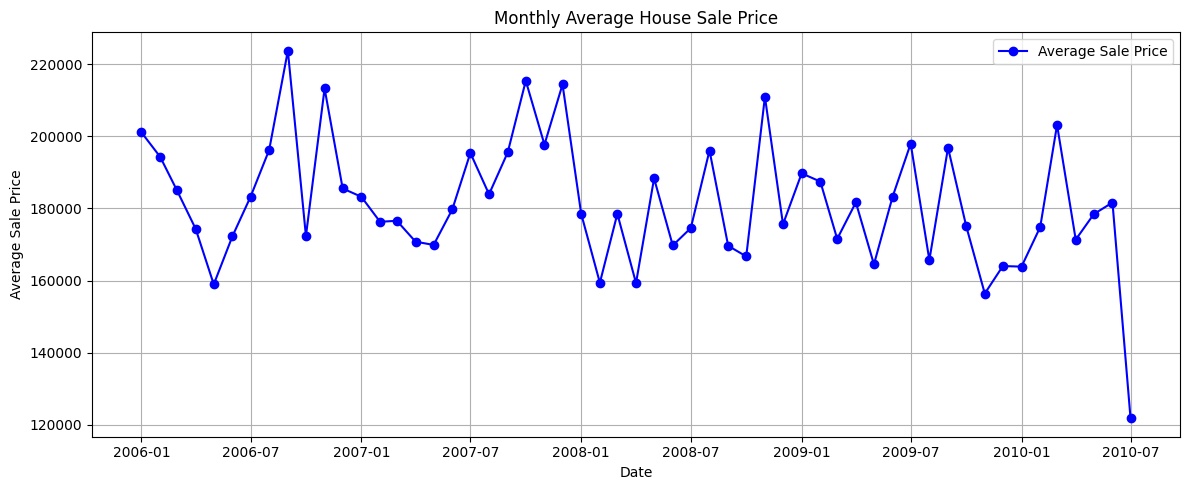

In [68]:
plt.figure(figsize=(12, 5))
plt.plot(ts, marker='o', linestyle='-', color='blue', label='Average Sale Price')
plt.title("Monthly Average House Sale Price")
plt.xlabel("Date")
plt.ylabel("Average Sale Price")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Here we see a moderate variability, but no linear trend and a possible light seasonality. To be sure of what we say we will do an additive seasonal decomposition.

#### Seasonal Decomposition

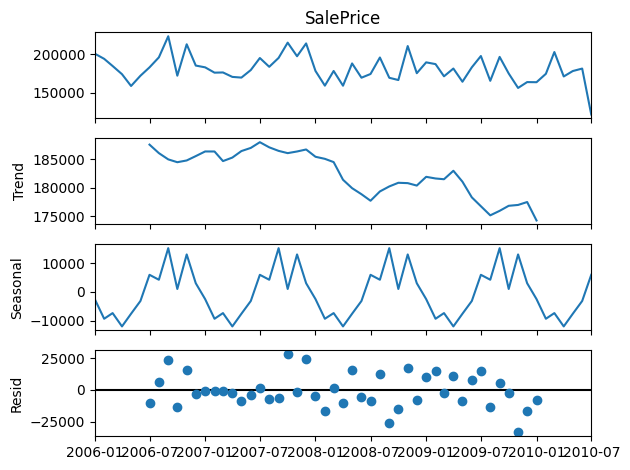

In [69]:
result = seasonal_decompose(ts, model='additive', period=12)
result.plot()
plt.show()

We can observe a slight downward trend and clear seasonality in the time series.

#### Simple differentiation and linear regression

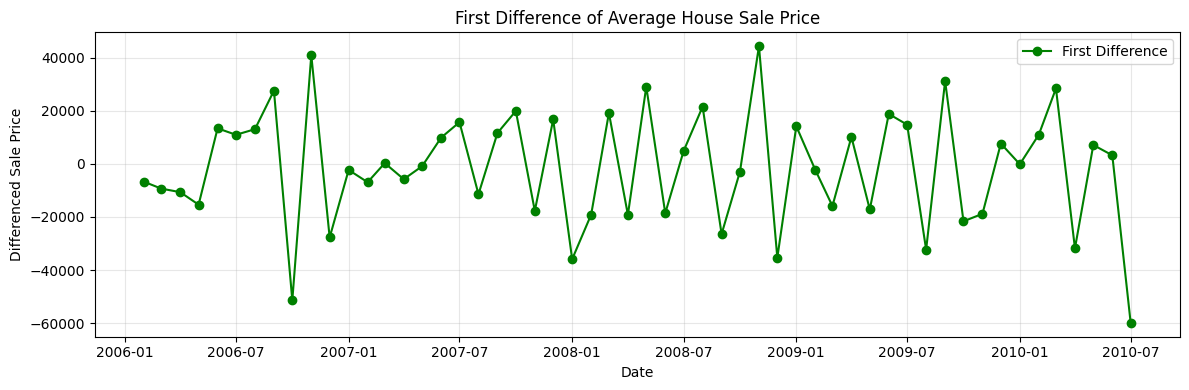

P-value original : 0.025435494179506406
P-value first difference : 0.6709843819714679


In [70]:
# Simple differentiation
ts_diff = ts.diff().dropna()

# Linear regression of the original series
X_orig = np.arange(len(ts)).reshape(-1, 1)
X_orig_const = sm.add_constant(X_orig)
model_orig = sm.OLS(ts.values, X_orig_const).fit()
pval_orig = model_orig.pvalues[1]

# Linear regression of the differentiated series
X_diff = np.arange(len(ts_diff)).reshape(-1, 1)
X_diff_const = sm.add_constant(X_diff)
model_diff = sm.OLS(ts_diff.values, X_diff_const).fit()
pval_diff = model_diff.pvalues[1]

# Plot of the differentiated series
plt.figure(figsize=(12, 4))
plt.plot(ts_diff, marker='o', linestyle='-', color='green', label='First Difference')
plt.title("First Difference of Average House Sale Price")
plt.xlabel("Date")
plt.ylabel("Differenced Sale Price")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print("P-value original :", pval_orig)
print("P-value first difference :", pval_diff)

The original series presents a significant linear trend $(<0.05)$ and after differentiation the trend is deleted, so we can set $d=1$ for our futur SARIMA model.

#### Combined differentiation

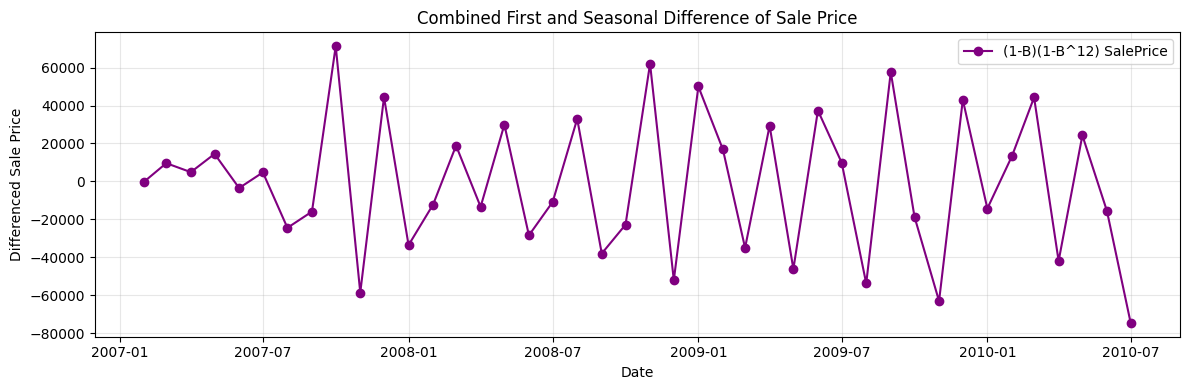

In [71]:
# Combined differentiation
combined_diff = ts.diff().dropna().diff(12).dropna()

# Combined differentiation plot
plt.figure(figsize=(12, 4))
plt.plot(combined_diff, marker='o', linestyle='-', color='purple', label='(1-B)(1-B^12) SalePrice')
plt.title("Combined First and Seasonal Difference of Sale Price")
plt.xlabel("Date")
plt.ylabel("Differenced Sale Price")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


The series is centered around 0, without any evident visual structure. This suggests that the trend and seasonality have been efficiently removed. The series is now a good candidate for a AR/MA model.

#### ACF/PACF plots

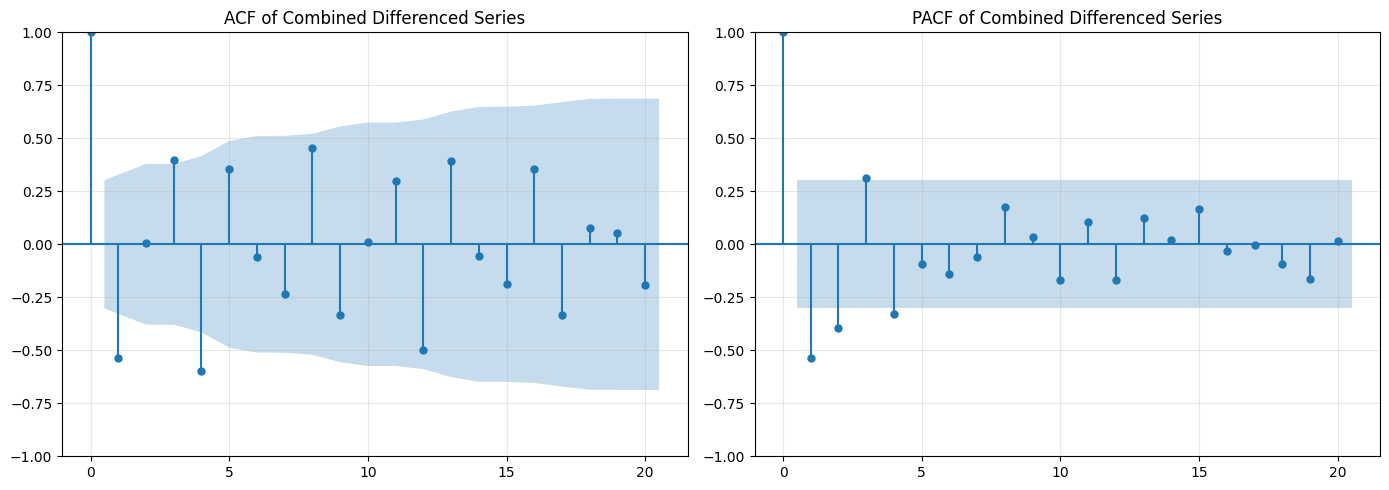

In [72]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plot_acf(combined_diff, lags=20, ax=axes[0])
axes[0].set_title("ACF of Combined Differenced Series")
axes[0].grid(True, alpha=0.3)

plot_pacf(combined_diff, lags=20, ax=axes[1])
axes[1].set_title("PACF of Combined Differenced Series")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

From the ACF and PACF we cannot see any AR/MA structure. So we will start with an ARIMA model (0,1,0) and test the following ARIMA orders and check their AIC/BIC to see which one is the best model:
- ARIMA(1,1,0)
- ARIMA(0,1,1)
- ARIMA(1,1,1)

#### Comparaison des différents modèles ARIMA

In [73]:
# Orders to test
orders_to_test = [(0, 1, 0), (1, 1, 0), (0, 1, 1), (1, 1, 1)]

# Stock the results
results_arima = []

for order in orders_to_test:
    try:
        model = ARIMA(ts, order=order).fit()
        results_arima.append({
            'Order': order,
            'AIC': model.aic,
            'BIC': model.bic,
        })
    except Exception as e:
        results_arima.append({
            'Order': order,
            'AIC': None,
            'BIC': None,
            'Error': str(e)
        })

# Conversion into a DataFrame for a better view
results_df = pd.DataFrame(results_arima).sort_values(by='AIC')

results_df

,Order,AIC,BIC
2,"(0, 1, 1)",1230.819690,1234.797658
1,"(1, 1, 0)",1232.021891,1235.999859
3,"(1, 1, 1)",1232.639542,1238.606494
0,"(0, 1, 0)",1235.623413,1237.612397


From this table we see that the best order for the ARIMA model would be the $(0,1,1)$. We will now check the residuals.

##### Residuals ACF/PACF

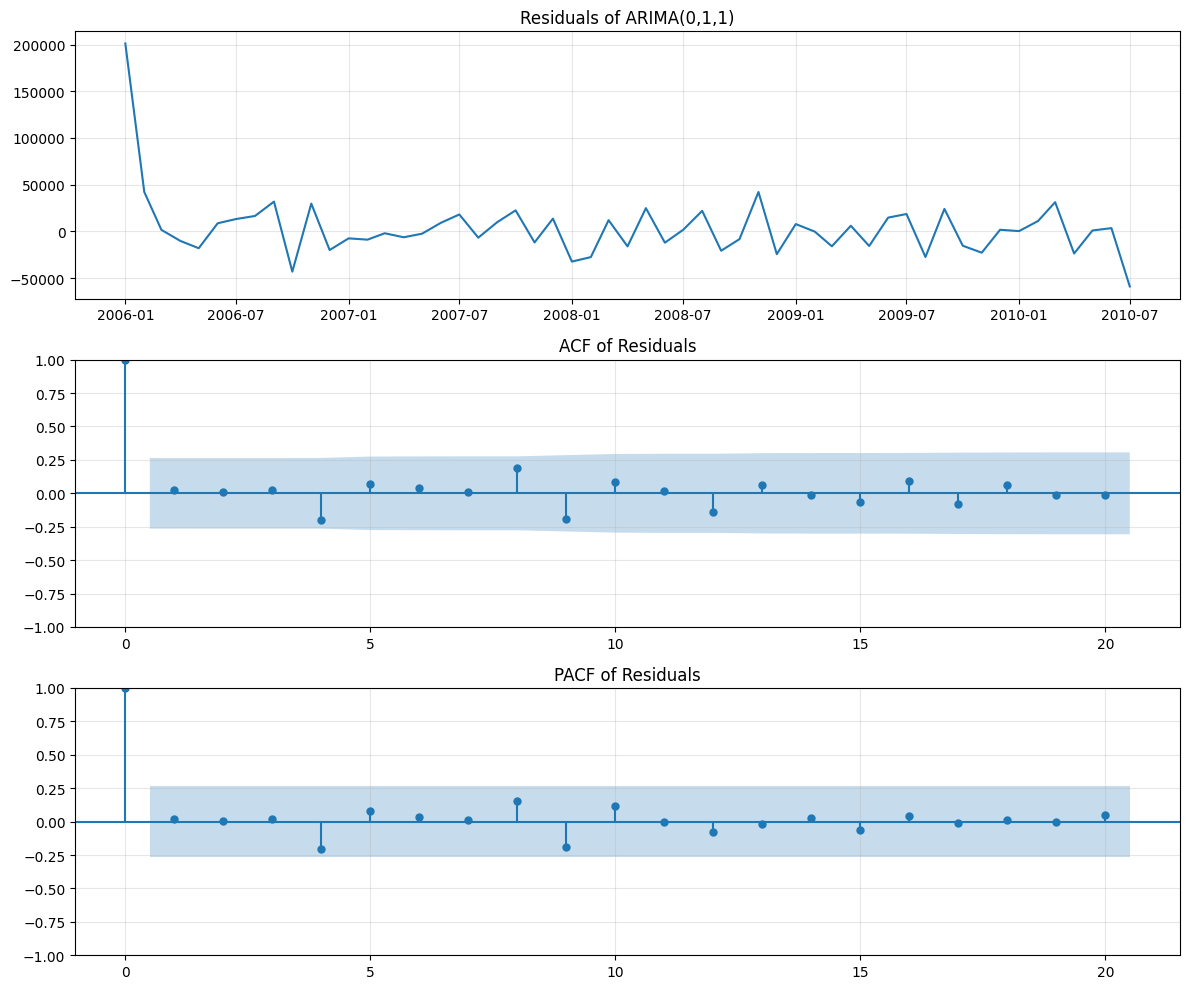

In [74]:
# Refit of the ARIMA(0,1,1) model
best_arima = ARIMA(ts, order=(0, 1, 1)).fit()

# Recuperate the residuals
residuals = best_arima.resid.dropna()

# Plot the residuals, their ACF and PACF
fig, ax = plt.subplots(3, 1, figsize=(12, 10))

# Résiduals over time
ax[0].plot(residuals)
ax[0].set_title("Residuals of ARIMA(0,1,1)")
ax[0].grid(True, alpha=0.3)

# Residuals ACF
plot_acf(residuals, lags=20, ax=ax[1])
ax[1].set_title("ACF of Residuals")
ax[1].grid(True, alpha=0.3)

# Residuals PACF
plot_pacf(residuals, lags=20, ax=ax[2])
ax[2].set_title("PACF of Residuals")
ax[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


The residuals are centered around 0, without any visible trend or cyclic structure. We see a constant variation, which suggests no strong heteroskedaticity.

The autocorrelation of the residuals is globally 0. This suggests that the model captures well the series.

The PACF doesn't show any significant spike: the values are randomly distributed around 0.

#### SARIMA model estimation

In [75]:
# List of SARIMA configs to test
sarima_configs = [
    ((0, 1, 1), (0, 1, 1, 12)),  # ARIMA(0,1,1) + seasonal MA 
    ((0, 1, 1), (1, 1, 0, 12)),  # ARIMA(0,1,1) + seasonal AR
    ((0, 1, 1), (1, 1, 1, 12)),  # ARIMA(0,1,1) + seasonal AR and MA
    ((0, 1, 1), (0, 1, 0, 12)),  # ARIMA(0,1,1) + without any AR and MA seasonality
]

# Stock results
sarima_results = []

for order, seasonal in sarima_configs:
    try:
        model = SARIMAX(ts, order=order, seasonal_order=seasonal,
                        enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
        sarima_results.append({
            'Order': order,
            'Seasonal': seasonal,
            'AIC': model.aic,
            'BIC': model.bic,
        })
    except Exception as e:
        sarima_results.append({
            'Order': order,
            'Seasonal': seasonal,
            'AIC': None,
            'BIC': None,
            'Error': str(e)
        })

# Print the results sorted by AIC
sarima_df = pd.DataFrame(sarima_results).sort_values(by='AIC')
sarima_df

,Order,Seasonal,AIC,BIC
1,"(0, 1, 1)","(1, 1, 0, 12)",703.287592,707.491184
3,"(0, 1, 1)","(0, 1, 0, 12)",940.566400,943.944159
0,"(0, 1, 1)","(0, 1, 1, 12)",1160.787457,1164.784071
2,"(0, 1, 1)","(1, 1, 1, 12)",1267.780954,1273.109772


From here we can retain the SARIMA model $(0,1,1)\times(1,1,0,12)$ closely followed by the $(0,1,1)\times(0,1,0,12)$ model.

#### Residuals analysis

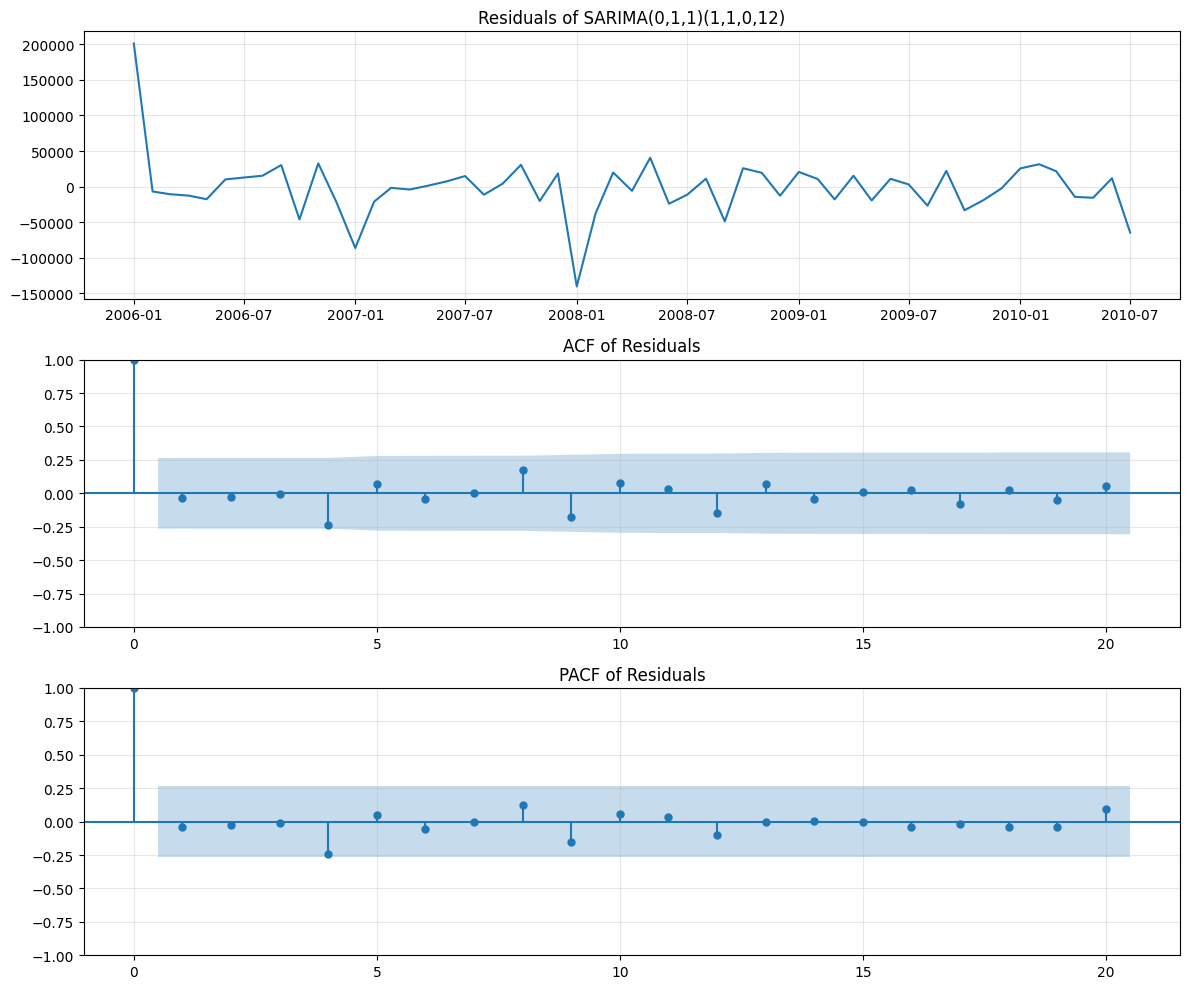

In [76]:
# Refit of the best SARIMA model
best_sarima = SARIMAX(ts, order=(0, 1, 1), seasonal_order=(1, 1, 0, 12),
                      enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)

# Model residuals
resid_sarima = best_sarima.resid.dropna()

# Plot the residuals, ACF and PACF
fig, ax = plt.subplots(3, 1, figsize=(12, 10))

# Residuals over time
ax[0].plot(resid_sarima)
ax[0].set_title("Residuals of SARIMA(0,1,1)(1,1,0,12)")
ax[0].grid(True, alpha=0.3)

# Residuals ACF
plot_acf(resid_sarima, lags=20, ax=ax[1])
ax[1].set_title("ACF of Residuals")
ax[1].grid(True, alpha=0.3)

# Residuals PACF
plot_pacf(resid_sarima, lags=20, ax=ax[2])
ax[2].set_title("PACF of Residuals")
ax[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


The residuals are globally centered around 0, without any visible trend or important variation of the variance over time.

No significant spike is visible in the autocorrelation plot. The PACF plot shows the same, that there is no presence of an residual AR structure. 

#### Summary results of the SARIMA model

In [77]:
model = SARIMAX(ts, order=(0, 1, 1), seasonal_order=(1, 1, 0, 12),
                      enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)

print(model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                           SalePrice   No. Observations:                   55
Model:             SARIMAX(0, 1, 1)x(1, 1, [], 12)   Log Likelihood                -348.644
Date:                             Mon, 26 May 2025   AIC                            703.288
Time:                                     12:23:50   BIC                            707.491
Sample:                                 01-01-2006   HQIC                           704.632
                                      - 07-01-2010                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1797      0.194     -0.927      0.354      -0.559       0.200
ar.S.L12      -0.8063      

Ljung-Box (Q) > 0.05 --> no autocorellation
Jarque-Bera (Q) > 0.05 --> normality hypothesis is accept

#### Forecasting

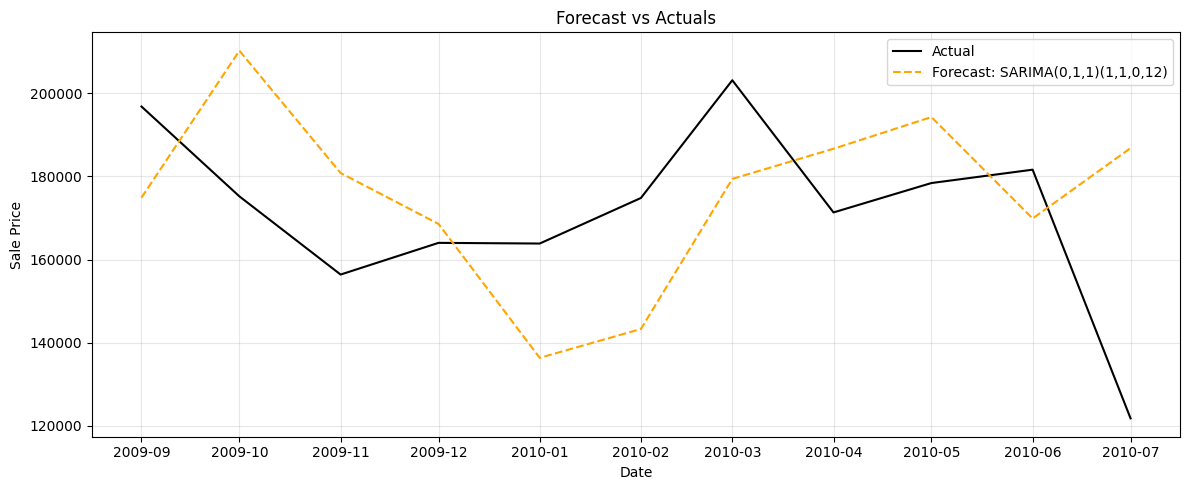

The mean square error of this model is 848730702.0788401


In [82]:
# Split train/test : 80% train, 20% test
n = len(ts)
split = int(n * 0.8)
train, test = ts.iloc[:split], ts.iloc[split:]

# Best model : SARIMA(0,1,1)(1,1,0,12)
order = (0, 1, 1)
seasonal_order = (1, 1, 0, 12)

preds = []
actuals = []
history = train.copy()

for t in range(len(test)):
    model = SARIMAX(history,
                    order=order,
                    seasonal_order=seasonal_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False).fit(disp=False)
    
    forecast = model.forecast(steps=1).iloc[0]
    actual = test.iloc[t]

    preds.append(forecast)
    actuals.append(actual)

    history = pd.concat([history, test.iloc[[t]]])

# Mean squared error and plot
forecast_error = np.array(actuals) - np.array(preds)
forecast_variance = np.var(forecast_error)

plt.figure(figsize=(12, 5))
plt.plot(test.index, actuals, label="Actual", color="black")
plt.plot(test.index, preds, label="Forecast: SARIMA(0,1,1)(1,1,0,12)", linestyle="--", color="orange")
plt.title("Forecast vs Actuals")
plt.xlabel("Date")
plt.ylabel("Sale Price")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f'The mean square error of this model is {forecast_variance}')
